## Capstone Project - The Battle of Neighborhoods (Week 1)

### Introduction

####  Description of the problem and a discussion of the background

Paris is the most densely populated capital city in Europe and the fourth in the world
(21,498/km² - 53,000/sq mi).
As a consequence the real estate prices are amongst the highest in the world ( 8th in the world with 14,017.63 $  per square meter).

Paris being a city where relatively few people possess a car (due to excessive taxes and parking fees). So a car rental agency can be a juicy business because a lot of residents may need occasionally a car

For this project let's put ourselves in the shoes of an entrepreneur looking to open a car rental agency. So for the location we have to find a balance between the real estate prices and the presence of competitors. 



### Table of content
[1. Data Description](#Data_Description)

[2. Methodology](#Methodology)

[3. Results](#Results)

[4. Discussion](#Discussion)

[5. Conclusion](#Conclusion)

[6. References](#References)

Before starting the analysis let's import all the needed libraries :

In [103]:
import pandas as pd
!pip install geocoder
import geocoder # import geocoder
!pip install geopy
from geopy.geocoders import Nominatim 
!pip install folium
import folium
import requests
import json
import numpy as np
# import k-means from clustering stage
from sklearn.cluster import KMeans
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

<a id='Data_Description'></a>

### 1. Data Description
To solve this problem we will use the following data :

* An excel file (Arrondissements_Paris.xlsx) downloaded from "Open platform for French public data"  containing the list of all the Paris districts with their coordinates. [1]

* Foursquare API to get the car rental agencies for each district [2]

* The real estate prices for all Paris districts [3]


<a id='Methodology'></a>

### 2. Methodology

##### Loading and exploring dataset

I gathered for all the districts  the coordinates and the housing prices in one file "Arrondissements_Paris.xlsx".
Let's import it:

In [104]:
paris_districts_df=pd.read_excel('Arrondissements_Paris.xlsx')
paris_districts_df.head()



,PostalCode,District_Number,Numéro d’arrondissement INSEE,Nom de l’arrondissement,District_Name,N_SQ_CO,Surface,Périmètre,Latitude,Longitude,average housing price
0,75017,17,75117,17ème Ardt,Batignolles-Monceau,750001537,5.668835e+06,10775.579516,48.883669,2.303638,10210
1,75020,20,75120,20ème Ardt,Ménilmontant,750001537,5.983446e+06,10704.940486,48.865439,2.400913,8560
2,75009,9,75109,9ème Ardt,Opéra,750001537,2.178303e+06,6471.588290,48.877164,2.337458,10730
3,75018,18,75118,18ème Ardt,Buttes-Montmartre,750001537,5.996051e+06,9916.464176,48.892569,2.348161,9360
4,75003,3,75103,3ème Ardt,Temple,750001537,1.170883e+06,4519.263648,48.862872,2.360001,12260


We will keep only the following columns : PostalCode,District_Number,District_Name and the coordinates

In [105]:
paris_districts_df=paris_districts_df[['PostalCode','District_Number','District_Name','Latitude','Longitude','average housing price']]
paris_districts_df.head()

,PostalCode,District_Number,District_Name,Latitude,Longitude,average housing price
0,75017,17,Batignolles-Monceau,48.883669,2.303638,10210
1,75020,20,Ménilmontant,48.865439,2.400913,8560
2,75009,9,Opéra,48.877164,2.337458,10730
3,75018,18,Buttes-Montmartre,48.892569,2.348161,9360
4,75003,3,Temple,48.862872,2.360001,12260


##### Use geopy library to get the latitude and longitude values of Paris

In [106]:
address = 'Paris, Île-de-France, France'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Paris are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Paris are 48.8566969, 2.3514616.


##### Paris districts visualization

In [107]:
# create map of Paris using latitude and longitude values
map_paris = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng,neighborhood in zip(paris_districts_df['Latitude'], paris_districts_df['Longitude'], paris_districts_df['District_Name']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_paris)  
    
map_paris

Next, we are going to use the Foursquare API to find all the car rental agencies in the 20 districts

##### Define Foursquare Credentials and Version

In [108]:
CLIENT_ID = 'FI0NVYWODT3CVTGQXA3CAU5EYXQ4OTAEUBECRSIL44SAOQVU' # your Foursquare ID
CLIENT_SECRET = 'KOYST14NLBRHIX2GNX4EK2RNSOLNYX0QFECBQ2OBZDEFWSNE' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: FI0NVYWODT3CVTGQXA3CAU5EYXQ4OTAEUBECRSIL44SAOQVU
CLIENT_SECRET:KOYST14NLBRHIX2GNX4EK2RNSOLNYX0QFECBQ2OBZDEFWSNE


Let's use the getNearbyVenues from the lab "Segmenting and Clustering Neighborhoods in New York City"

In [109]:
def getNearbyVenues(PostalCode,names, latitudes, longitudes, categoryid_search="4bf58dd8d48988d1ef941735", radius=1000 ):
    

    venues_list=[]
    for pc, name, lat, lng in zip(PostalCode, names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&radius={}&intent=browse'.format(CLIENT_ID, CLIENT_SECRET, lat, lng, VERSION, categoryid_search, radius)

            
        # make the GET request
        results = requests.get(url).json()['response']['venues']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            pc,
            name, 
            lat, 
            lng, 
            v['name'], 
            v['location']['lat'], 
            v['location']['lng']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Postal_code',
                  'District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude']
    
    return(nearby_venues)

Let's run the above function to create a data frame containing all the car rental agencies of Paris

In [110]:
paris_car_rental = getNearbyVenues(PostalCode=paris_districts_df['PostalCode'],
                                   names=paris_districts_df['District_Name'],
                                   latitudes=paris_districts_df['Latitude'],
                                   longitudes=paris_districts_df['Longitude'])
                                  



Batignolles-Monceau
Ménilmontant
Opéra
Buttes-Montmartre
Temple
Palais-Bourbon
Popincourt
Vaugirard
Gobelins
Panthéon
Élysée
Reuilly
Passy
Luxembourg
Louvre
Bourse
Buttes-Chaumont
Entrepôt
Hôtel-de-Ville
Observatoire


Let's check the size of the resulting data frame

In [85]:
paris_car_rental.shape

(556, 7)

In [128]:
#The "autolib' station" are not car rent agencies but self service cars 
#So Let's remove them
paris_car_rental=paris_car_rental[paris_car_rental['Venue'] != "Autolib’ Station" ]
paris_car_rental=paris_car_rental[paris_car_rental['Venue'] != "Autolib' Station"]



# let's count the numbre of car agencies per district
car_rental_agencies=paris_car_rental.groupby(['Postal_code'])['Venue'].count().to_frame()
car_rental_agencies.columns=['Number_of_car_agencies']
car_rental_agencies.reset_index(inplace=True)


Merge the number of car rental agencies per district with the data frame paris_districts_df

In [112]:
paris_districts_df.sort_values(by=['PostalCode'],inplace=True)
paris_districts_df.reset_index(inplace=True)
paris_districts_df['Car_rental_agencies']=car_rental_agencies['Number_of_car_agencies']
paris_districts_df


,index,PostalCode,District_Number,District_Name,Latitude,Longitude,average housing price,Car_rental_agencies
0,14,75001,1,Louvre,48.862563,2.336443,12840,17
1,15,75002,2,Bourse,48.868279,2.342803,11250,11
2,4,75003,3,Temple,48.862872,2.360001,12260,11
3,18,75004,4,Hôtel-de-Ville,48.854341,2.357630,12790,13
4,9,75005,5,Panthéon,48.844443,2.350715,12140,12
5,13,75006,6,Luxembourg,48.849130,2.332898,14180,13
6,5,75007,7,Palais-Bourbon,48.856174,2.312188,13230,10
7,10,75008,8,Élysée,48.872721,2.312554,11240,14
8,2,75009,9,Opéra,48.877164,2.337458,10730,11
9,17,75010,10,Entrepôt,48.876130,2.360728,9730,18


Let's determine the total number of car rental agencies in Paris

In [113]:
number_car_rental_agencies=paris_districts_df['Car_rental_agencies'].sum().astype(str)


print ('There are '+ number_car_rental_agencies +' car rental agencies in Paris')

There are 228 car rental agencies in Paris


#### Clustering  Dsitricts with Kmeans method


So first let's extract the relevant data ( the column "Car_rental_agencies" which contains the number of car rental agencies for each district and the "average housing price")

In [114]:
clustering_data = paris_districts_df[['Car_rental_agencies','average housing price']]

#We use StandardScaler() to normalize our dataset.

clustering_data = StandardScaler().fit_transform(clustering_data)

We will use unsupervised learning K-means algorithm to cluster the districts because the data is unlabeled

In [115]:

Sum_of_squared_distances = []

# For each k value, we will initialise k-means and use the inertia attribute to identify 
# the sum of squared distances of samples to the nearest cluster centre.
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(clustering_data)
    Sum_of_squared_distances.append(km.inertia_)

Let's plot the sum of squared distances for k

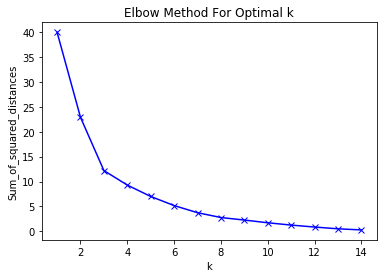

In [116]:
import matplotlib.pyplot as plt

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In the plot above the elbow is at k=3 indicating the optimal k for this dataset is 3

Let's define a clustering model with k=3 and train it

In [117]:

kclusters=3
km_opt = KMeans(n_clusters=kclusters)
km_opt = km_opt.fit(clustering_data)

labels=km_opt.labels_

labels

array([1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 2, 2])

Let's assign a cluster number to each row (district)

In [120]:
paris_districts_df['cluster']=labels
paris_districts_df.head()

,index,PostalCode,District_Number,District_Name,Latitude,Longitude,average housing price,Car_rental_agencies,cluster
0,14,75001,1,Louvre,48.862563,2.336443,12840,17,1
1,15,75002,2,Bourse,48.868279,2.342803,11250,11,0
2,4,75003,3,Temple,48.862872,2.360001,12260,11,1
3,18,75004,4,Hôtel-de-Ville,48.854341,2.357630,12790,13,1
4,9,75005,5,Panthéon,48.844443,2.350715,12140,12,1


<a id='Results'></a>

### 3. Results

Let's visualize the resulting clusters

In [122]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

#folium.LayerControl(collapsed=True).add_to(map_clusters)
map_clusters

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(paris_districts_df['Latitude'],paris_districts_df['Longitude'], paris_districts_df['District_Name'], paris_districts_df["cluster"].astype(int)):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-2],
        fill=True,
        fill_color='k',
        fill_opacity=0.7).add_to(map_clusters)
    
       
map_clusters

We can label the clusters as follows :
 * Cluster 0 (green markers) : High number of car rental agencies and low housing prices
 * Cluster 1 (red markers) : High number of car rental agencies and high housing prices
 * Cluster 2 (purple markers) : low number of car rental agencies and low housing prices

Let's replace the cluster numbers by these new labels in the data frame


I retrieved  a json file file 'arrondissements.geojson' with the paris district coordinates.

Let's create a choropleth map containing 

* The district name
* The cluster name
* The average housing price


In [124]:
paris_data=r'arrondissements.geojson'


# generate choropleth map using the average housing price
add_choropleth=folium.Choropleth(
    geo_data=paris_data,
    data=paris_districts_df,
    columns=['District_Name', 'average housing price'],
    key_on='feature.properties.l_aroff',
    fill_color='Oranges', 
    fill_opacity=0.7, 
    line_opacity=0.5,
    legend_name='average housing price',
    reset=True,
    hightlight=True
).add_to(map_clusters)

#folium.LayerControl(collapsed=True).add_to(map_clusters)
map_clusters
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(paris_districts_df['Latitude'], paris_districts_df['Longitude'], paris_districts_df['District_Name'], paris_districts_df["cluster"].astype(int)):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-2],
        fill=False,
        fill_color='k',
        fill_opacity=0.7).add_to(map_clusters)
    
       
map_clusters

<a id='Discussion'></a>

### 4. Discussion

Our results show that there are relatively few car rental agencies in Paris (229) so our first intuition that Paris has relatively few car rental agencies  has been confirmed.



It seems wise to chose a district  from the cluster 0 with low density of car rental agencies and low housing prices such as "Buttes-Montmartre","Buttes-Chaumont","Ménilmontant","Passy" or "Observatoire" ( The purple marked in the above map).

Among these districts "Passy" and "Observatoire" would be a better choice since they draw an important business clientele.

These recommendations have to be considered only as a starting point,others factors have to be taken into account such as the road traffic and the availability of building lands in the concerned districts





<a id='Conclusion'></a>

### 5. Conclusion

The aim of this project was to identify the best location to open a car rental agency that is to say a district with few car rental agencies and low housing prices.

By using KMeans clustering method with data coming from Foursquare API we clustered Paris districts into 3 clusters: 

* Cluster 0 : High number of car rental agencies and low housing prices
* Cluster 1 : High number of car rental agencies and high housing prices
* Cluster 2 : low number of car rental agencies and low housing prices

We highlighted that the cluster 2 was the better choice. 

This cluster contains the following district : "Buttes-Montmartre","Buttes-Chaumont","Ménilmontant","Passy" or "Observatoire"


Besides of this recommendation the final decision must to take into account some more factors such as
the road traffic and the availability of building lands.




<a id='References'></a>

### 6. References

* [1] [Paris districts coordinates](https://www.data.gouv.fr/fr/datasets/arrondissements-1/) 

* [2] [Foursquare API](https://developer.foursquare.com/)

* [3] [Average housing prices in Paris](https://droit-finances.commentcamarche.com/faq/7409-immobilier-a-paris-prix-au-m2-des-arrondissements)